# MEMO
- 手術開始、手術終了は度のデータでもできそう
- 他のイベントについてまとめる
- データセット4だけ、正解:その他、予測:外回りが多いため、イベントフラグが立ちやすい

In [1]:
%cd /raid6/home/yokoyama/har-for-or/
import os
from glob import glob
import pickle
import math

import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn.functional as F
from tqdm import tqdm

from src.data import load_dataset_iterable
from src.model import SQVAE
from src.utils import video, yaml_handler, vis

/raid6/home/yokoyama/har-for-or


/raid6/home/yokoyama/har-for-or/.venv/lib/python3.10/site-packages/mmengine/optim/optimizer/zero_optimizer.py:11: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import \


In [2]:
dataset_num = 3
model_type = "sqvae"

if dataset_num == 3:
    v = 0
elif dataset_num == 4:
    v = 1
elif dataset_num == 5:
    v = 2
checkpoint_dir = f"models/individual/{model_type}/version_{v}"

# load classes
path = f"../datasets/dataset{dataset_num:02d}/annotation/classes.txt"
classes = np.loadtxt(path, str, usecols=0, delimiter=",")
classes = [c.title() for c in classes]

# load annotation
path = glob(f"../datasets/dataset{dataset_num:02d}/annotation/*test*.txt")[0]
video_num = int(os.path.basename(path).split(".")[0].split("_")[2])
annotations = np.loadtxt(path, str, skiprows=1, delimiter=" ")

# load config
config = yaml_handler.load(f"{checkpoint_dir}/individual-{model_type}.yaml")
seq_len = config.seq_len
stride = config.stride
if config.mask_leg:
    n_pts = 13 + 2
else:
    n_pts = 17 + 2

In [15]:
target_label = 3

In [16]:
data_dirs = glob(f"../datasets/dataset{dataset_num:02d}/train/*/") + glob(
    f"../datasets/dataset{dataset_num:02d}/test/*/"
)
data_dirs = sorted(data_dirs, key=lambda x: int(os.path.basename(os.path.dirname(x))))

label_counts_all = {}
book_indices_miss_counts_all = {}
for data_dir in tqdm(data_dirs):
    video_num = os.path.basename(os.path.dirname(data_dir))

    # load preds
    results = []
    paths = glob(os.path.join(data_dir, f"pred_{model_type}", "*"))
    for path in paths:
        with open(path, "rb") as f:
            results.append(pickle.load(f))

    label_counts = {i: {} for i in range(config.n_clusters)}
    book_indices_miss_counts = {}
    pre_bi_dict = {}
    max_n_frame = 0
    for result in results:
        _, n_frame, _id = result["key"].split("_")
        n_frame = int(n_frame)
        _id = int(_id)
        bi = result["book_idx"]
        label = result["label"]

        if max_n_frame < n_frame:
            max_n_frame = n_frame

        # label count
        label_pred = int(result["label"])
        if n_frame not in label_counts[label_pred]:
            label_counts[label_pred][n_frame] = 0
        label_counts[label_pred][n_frame] += 1

        # book indices miss counts
        if label == target_label:
            if _id not in book_indices_miss_counts:
                pre_bi_dict[_id] = (n_frame, bi)
                book_indices_miss_counts[_id] = {}
            pre_nf, pre_bi = pre_bi_dict[_id]
            if pre_nf + stride == n_frame:
                miss_count = np.count_nonzero(pre_bi != bi)
                book_indices_miss_counts[_id][n_frame] = miss_count
            pre_bi_dict[_id] = (n_frame, bi)

    # collect label counts
    vals_tmp = []
    for label, count_dict in label_counts.items():
        if len(count_dict) < 2:
            continue
        n_frames = np.array(list(count_dict.keys()))
        counts = np.array(list(count_dict.values()))

        idxs = n_frames // stride
        n_samples = max_n_frame // stride + 1
        vals = np.zeros((n_samples,), np.int32)
        vals[idxs] = counts

        vals_tmp.append(vals)
    vals = np.array(vals_tmp).T
    label_counts_all[video_num] = vals

    # collect book indices miss countq
    vals_tmp = []
    for _id, count_dict in book_indices_miss_counts.items():
        if len(count_dict) < 1:
            continue
        n_frames = np.array(list(count_dict.keys()))
        counts = np.array(list(count_dict.values()))

        idxs = n_frames // stride
        n_samples = max_n_frame // stride + 1
        vals = np.zeros((n_samples,), np.int32)
        vals[idxs] = counts
        vals_tmp.append(vals)
    vals = np.array(vals_tmp).T
    book_indices_miss_counts_all[video_num] = vals

100%|██████████| 19/19 [00:11<00:00,  1.63it/s]


In [17]:
def filter_label_counts(label_counts, label=3, th_n_label=3):
    vals = label_counts.T[label].copy()
    vals = vis.moving_average(vals, 5)
    vals = vals >= th_n_label
    return vals


def filter_book_indices_miss_counts(book_indices_miss_counts, th_n_pts, th_n_inds):
    vals = book_indices_miss_counts.copy()
    vals = np.count_nonzero(vals >= th_n_pts, axis=1)
    vals = vis.moving_average(vals, 5)
    vals = vals >= th_n_inds
    return vals


def noise_canceling(vals, th_interval):
    ret = []
    interval = 0
    flg_first_true = False
    for i, val in enumerate(vals):
        if val == 1:
            interval = 0
            ret.append(1)
            flg_first_true = True
        else:
            interval += 1
            if interval < th_interval and flg_first_true:
                ret.append(1)
            else:
                ret.append(0)

    return np.array(ret)

01


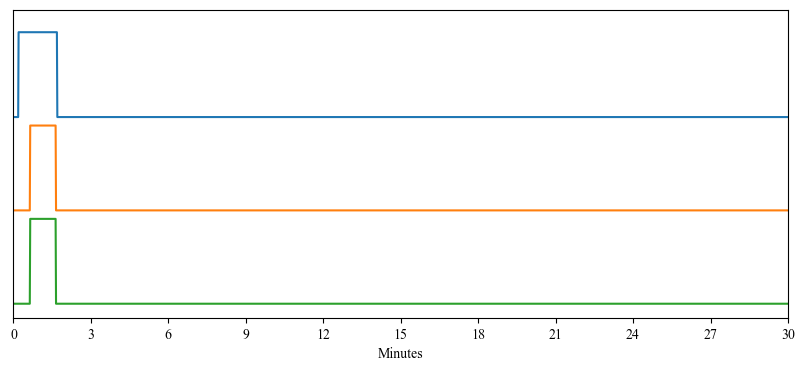

[[39 99]]
02


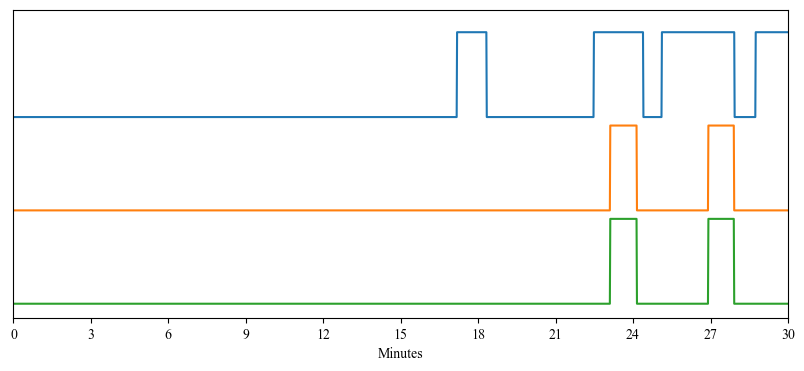

[[1387 1449]
 [1615 1675]]
03


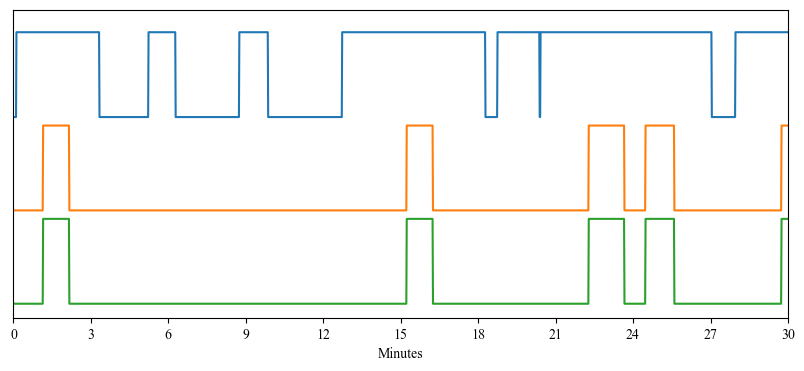

[[  69  130]
 [ 914  975]
 [1337 1420]
 [1469 1536]
 [1785 1800]]
04


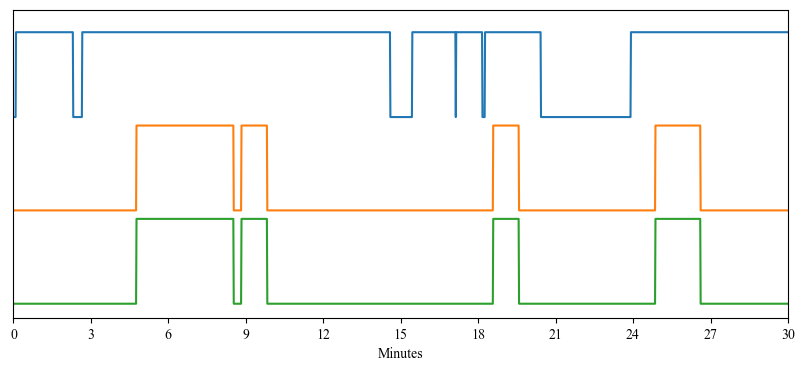

[[ 286  512]
 [ 530  590]
 [1115 1175]
 [1492 1597]]
05


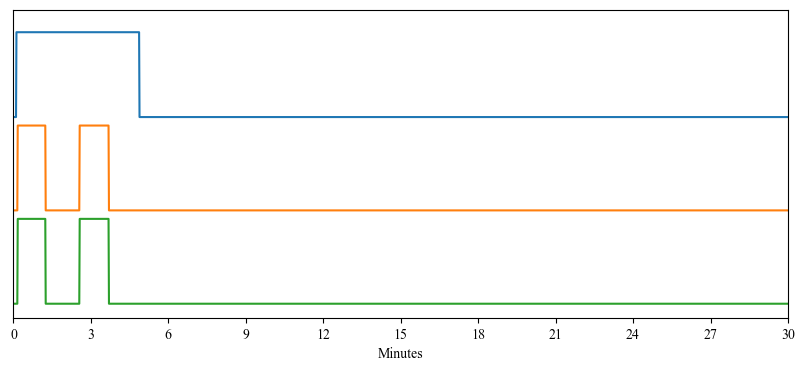

[[ 10  75]
 [154 222]]
06


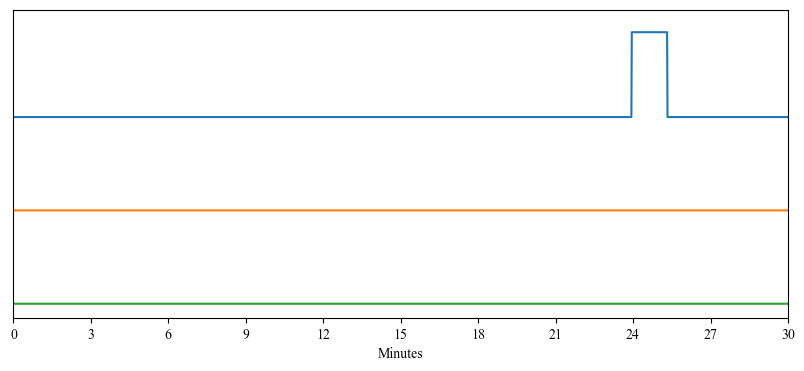

07


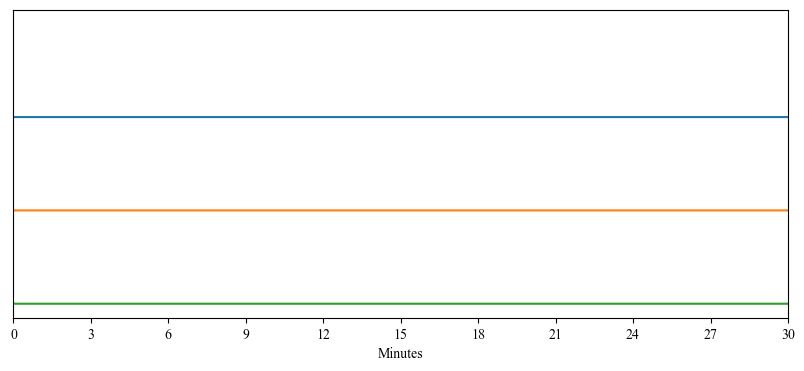

08


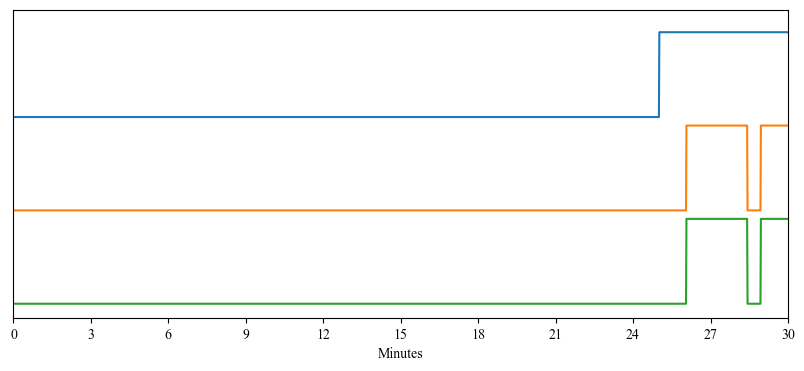

[[1564 1706]
 [1737 1800]]
09


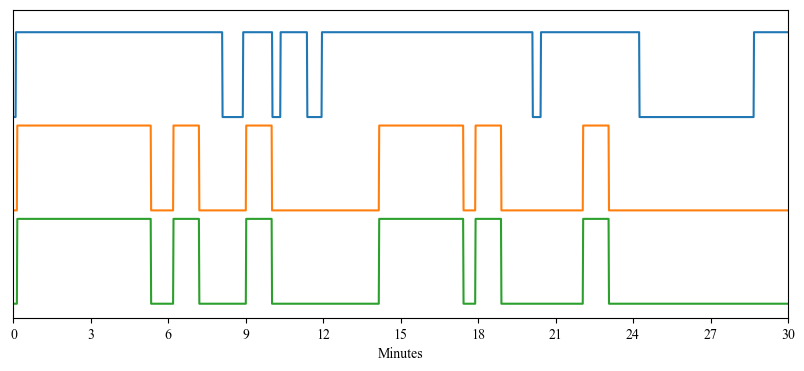

[[   9  320]
 [ 372  432]
 [ 541  601]
 [ 850 1046]
 [1074 1134]
 [1324 1384]]
10


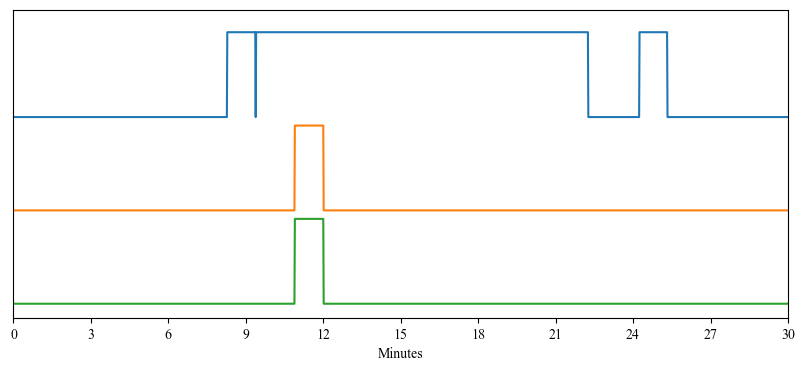

[[654 721]]
11


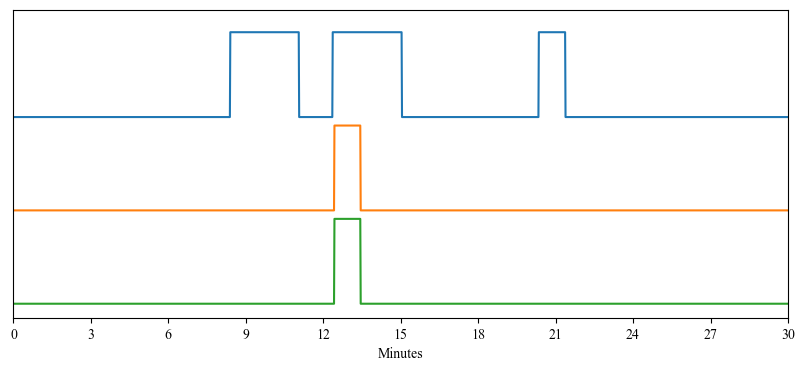

[[746 807]]
12


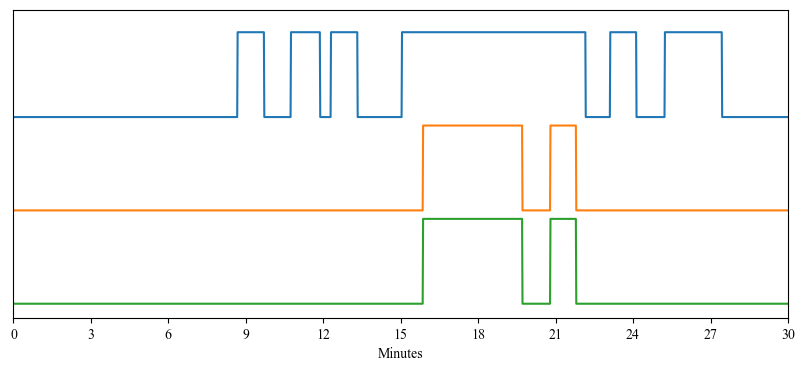

[[ 952 1183]
 [1248 1308]]
13


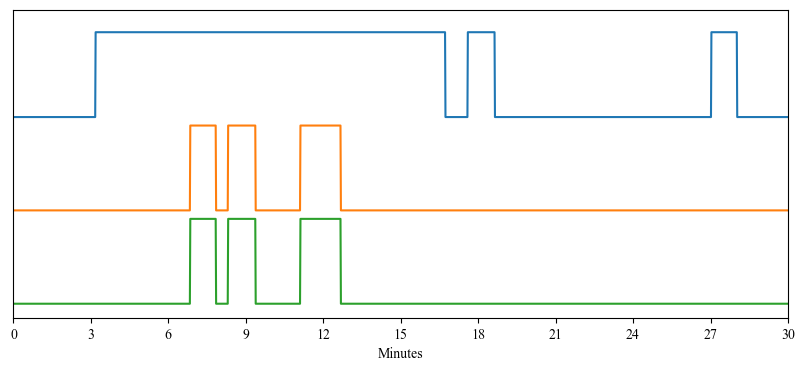

[[411 471]
 [499 563]
 [667 761]]
14


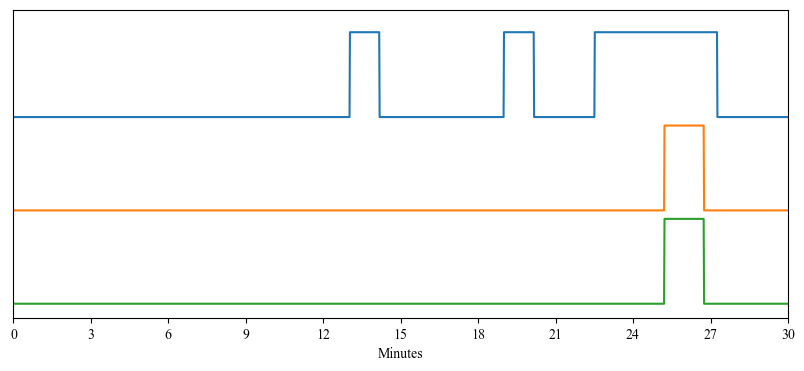

[[1513 1605]]
15


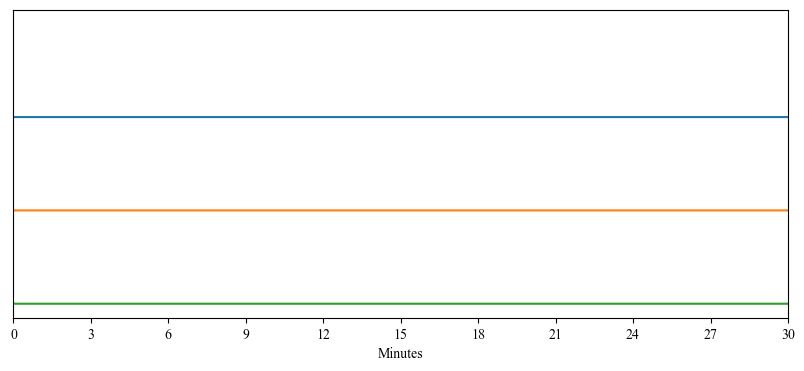

16


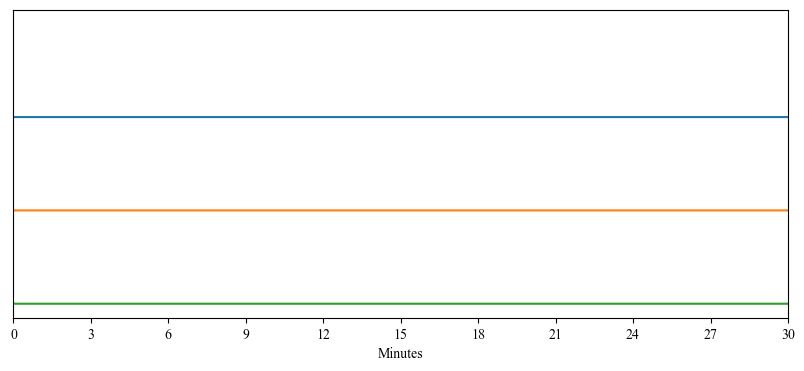

17


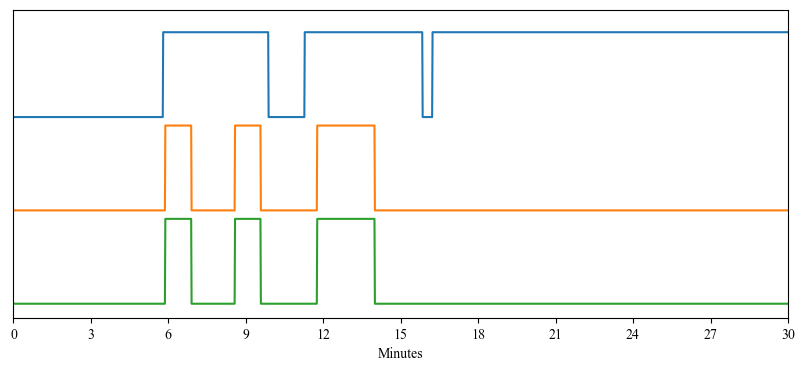

[[353 414]
 [515 575]
 [706 840]]
18


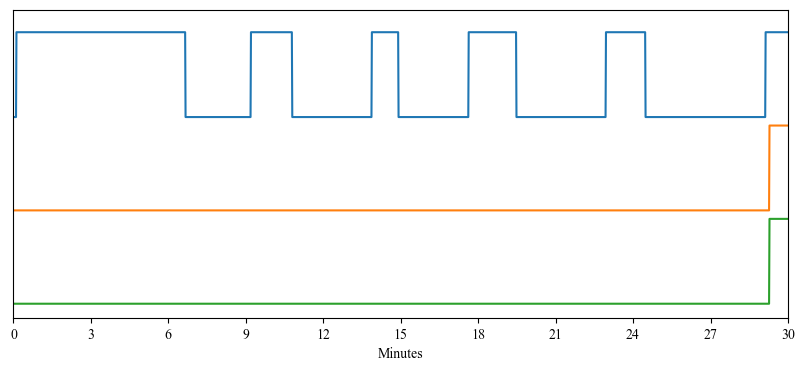

[1757] 1
[[1757 1800]]
19


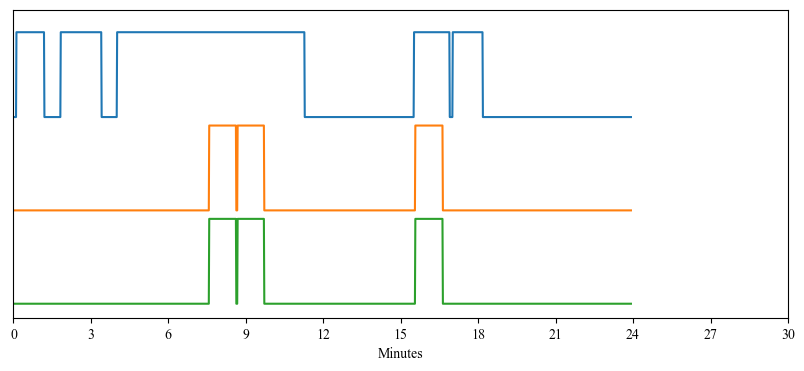

[[455 518]
 [521 583]
 [934 998]]


In [18]:
th_n_label = 3  # label count
th_n_pts = 1  # book indices
th_n_inds = 3  # book indices
th_interval = 60  # noise canceling


event_frames_all = {}
for video_num in label_counts_all.keys():
    print(video_num)

    lc_bin = filter_label_counts(label_counts_all[video_num], target_label, th_n_label)
    lc_bin = noise_canceling(lc_bin, th_interval)

    bimc_bin = filter_book_indices_miss_counts(
        book_indices_miss_counts_all[video_num], th_n_pts, th_n_inds
    )
    bimc_bin = noise_canceling(bimc_bin, th_interval)

    binary = lc_bin & bimc_bin

    plt.figure(figsize=(10, 4))
    plt.plot(lc_bin + 1.1 * 2)
    plt.plot(bimc_bin + 1.1)
    plt.plot(binary)
    plt.yticks([])
    plt.ylim(-3.3 * 0.05, 3.3 * 1.05)
    plt.xlim(0, 1801)
    plt.xticks(np.arange(0, 1801, 60 * 3), np.arange(0, 1801, 60 * 3) // 60)
    plt.xlabel("Minutes")
    plt.show()

    # diff_bin = np.diff(binary, prepend=0)
    # plt.figure(figsize=(10, 4))
    # plt.plot(diff_bin)
    # plt.yticks([])
    # plt.ylim(-1.05, 1.05)
    # plt.xlim(0, 1801)
    # plt.xticks(np.arange(0, 1801, 60 * 3), np.arange(0, 1801, 60 * 3) // 60)
    # plt.xlabel("Minutes")
    # plt.show()

    diff_bin = np.diff(binary, prepend=0)
    start_n_frames = np.where(diff_bin > 0)[0]
    end_n_frames = np.where(diff_bin < 0)[0]

    if np.count_nonzero(diff_bin) == 1:
        idx = np.where(diff_bin != 0)[0]
        print(idx, diff_bin[idx].item())
        if diff_bin[idx].item() == 1:
            start_n_frames = np.array([idx.item()])
            end_n_frames = np.array([1800])
        else:
            start_n_frames = np.array([0])
            end_n_frames = np.array([idx.item()])
    elif len(start_n_frames) == 0 and len(end_n_frames) == 0:
        continue
    else:
        if start_n_frames[0] > end_n_frames[0]:
            start_n_frames = start_n_frames.tolist()
            start_n_frames.append(0)
            start_n_frames = np.array(start_n_frames)
        if start_n_frames[-1] > end_n_frames[-1]:
            end_n_frames = end_n_frames.tolist()
            end_n_frames.append(1800)
            end_n_frames = np.array(end_n_frames)
    event_frames = np.concatenate(
        [start_n_frames[:, None], end_n_frames[:, None]], axis=1
    )
    print(event_frames)
    event_frames_all[video_num] = event_frames

In [ ]:
# train_data_dirs = glob(f"../datasets/dataset{dataset_num:02d}/train/*/")
# train_video_nums = [os.path.basename(os.path.dirname(data_dir)) for data_dir in train_data_dirs]

# for video_num, event_frames in event_frames_all.items():
#     if len(event_frames) == 0:
#         continue

#     if video_num in train_video_nums:
#         data_dir = f"../datasets/dataset{dataset_num:02d}/train/{video_num}/"
#     else:
#         data_dir = f"../datasets/dataset{dataset_num:02d}/test/{video_num}/"

#     out_dir = f"{data_dir}/events"
#     os.makedirs(out_dir, exist_ok=True)

#     video_path = f"{data_dir}/pred_cluster.mp4"
#     cap = video.Capture(video_path)

#     for start_n_frame, end_n_frame in tqdm(event_frames, ncols=100, desc=video_num):
#         start_n_frame = max(0, start_n_frame - 60)
#         end_n_frame = min(1800, end_n_frame + 60)

#         start_n_frame *= stride
#         end_n_frame *= stride

#         out_path = f"{out_dir}/s{start_n_frame}_e{end_n_frame}.mp4"
#         wrt = video.Writer(out_path, cap.fps, cap.size)
#         cap.set_pos_frame_count(start_n_frame)
#         for i in tqdm(range(end_n_frame - start_n_frame), ncols=100):
#             frame = cap.read()[1]
#             wrt.write(frame)
#         del wrt
#     del cap